<a href="https://colab.research.google.com/github/KaiserKyle/IST-718-Final-Project/blob/master/Data_Analysis_Who's_In.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt  # 2D plotting
from matplotlib.cbook import boxplot_stats
import seaborn as sns 

In [0]:
data = pd.read_csv('agg_team_stats.csv' ,low_memory=False)
data = data.drop(['name', 'market', 'alias','conf_id','division_alias','conf_name'], axis=1)
data.fillna(0, inplace=True)
data.head()

,season,team_id,conf_alias,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,...,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,NCAA,Conference,Win,Loss,Conference_Champ
0,2013,8ddbfca9-a931-4908-aa31-9fcd17624b5f,CUSA,71.451613,22.25,60.500000,36.750000,5.500000,16.000000,34.875000,...,3.000000,0.000000,0.75,0.0,0.0,False,True,12.0,19.0,False
1,2013,11a617d5-af03-4cce-bc8a-51114d9e41fe,BIGWEST,69.741935,23.20,59.200000,38.830000,5.400000,19.600000,27.410000,...,3.900000,0.000000,0.00,0.0,0.0,False,True,11.0,20.0,False
2,2013,d8217105-e9c2-4267-9538-3aaeea1ae167,MVC,69.393939,22.00,53.333333,41.650000,4.666667,13.333333,35.916667,...,4.800000,0.166667,0.00,0.0,0.0,False,True,10.0,23.0,False
3,2013,5016fe1a-9571-4d10-bf5b-b9c1b496bd57,WAC,77.000000,22.00,56.666667,38.333333,4.333333,14.666667,28.266667,...,3.666667,0.333333,0.00,0.0,0.0,True,True,10.0,26.0,True
4,2013,53aaac6a-796e-41a6-a04e-6ce74c5717f8,MEAC,65.281250,16.00,48.500000,32.750000,7.000000,19.500000,34.500000,...,4.500000,0.000000,0.00,0.0,0.0,False,True,7.0,25.0,False


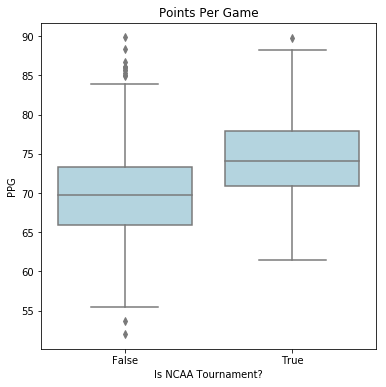

In [0]:
plt.rcParams['figure.figsize'] = [6, 6]
g = sns.boxplot(x="NCAA", y="points_game", data=data, color = "lightblue")
g.set(xlabel = "Is NCAA Tournament?", ylabel = "PPG")
g.set_title("Points Per Game")

plt.show()

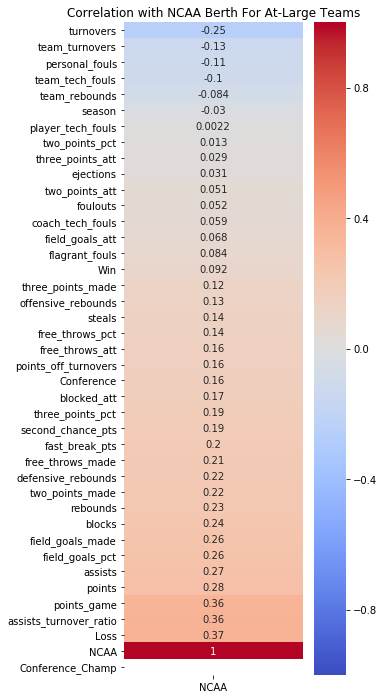

In [0]:
at_large_data = data[data.Conference_Champ == False]

plt.rcParams['figure.figsize'] = [4, 12]
corr = at_large_data.corr()
corr = corr.loc[['NCAA']].transpose().sort_values(by = 'NCAA')
g = sns.heatmap(corr, 
            yticklabels=corr.index.values,
            annot = True,
            center = 0,
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm')

plt.title("Correlation with NCAA Berth For At-Large Teams")

plt.show()

In [0]:
from sklearn import preprocessing
#enc = preprocessing.OneHotEncoder().fit(at_large_data['conf_name'])

train_data = at_large_data[(at_large_data['season'] == 2013) | (at_large_data['season'] == 2014) | (at_large_data['season'] == 2015)]
test_data = at_large_data[(at_large_data['season'] == 2016) | (at_large_data['season'] == 2017)]

y_test = test_data[['NCAA', 'season', 'team_id']]
y_train = train_data[['NCAA', 'season', 'team_id']]
X_test = test_data.drop(['NCAA', 'season', 'team_id', 'conf_alias'], axis=1)
X_train = train_data.drop(['NCAA', 'season', 'team_id', 'conf_alias'], axis=1)

X_train.head()

,points_game,field_goals_made,field_goals_att,field_goals_pct,three_points_made,three_points_att,three_points_pct,two_points_made,two_points_att,two_points_pct,...,points_off_turnovers,team_rebounds,flagrant_fouls,player_tech_fouls,team_tech_fouls,coach_tech_fouls,Conference,Win,Loss,Conference_Champ
0,71.451613,22.250000,60.500000,36.750000,5.500000,16.000000,34.875000,16.750000,44.500000,37.650000,...,10.750000,3.0,0.000000,0.750000,0.0,0.0,True,12.0,19.0,False
1,69.741935,23.200000,59.200000,38.830000,5.400000,19.600000,27.410000,17.800000,39.600000,44.050000,...,10.900000,3.9,0.000000,0.000000,0.0,0.0,True,11.0,20.0,False
2,69.393939,22.000000,53.333333,41.650000,4.666667,13.333333,35.916667,17.333333,40.000000,43.733333,...,7.666667,4.8,0.166667,0.000000,0.0,0.0,True,10.0,23.0,False
4,65.281250,16.000000,48.500000,32.750000,7.000000,19.500000,34.500000,9.000000,29.000000,31.200000,...,3.500000,4.5,0.000000,0.000000,0.0,0.0,True,7.0,25.0,False
5,64.676471,22.764706,53.558824,42.638235,5.794118,18.264706,31.802941,16.970588,35.294118,48.376471,...,13.147059,3.0,0.029412,0.117647,0.0,0.0,True,7.0,27.0,False


In [0]:
from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=1000)
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.764797507788162

In [0]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train.NCAA)
clf.score(X_test, y_test.NCAA)

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.67601246105919

In [0]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.NCAA)
neigh.score(X_test, y_test.NCAA)

0.6479750778816199

In [0]:
from sklearn.ensemble import RandomForestClassifier 

forest = RandomForestClassifier(n_estimators = 500)
forest.fit(X_train, y_train.NCAA)
print('Random Forest Score: ', forest.score(X_test, y_test.NCAA))

predictions = pd.DataFrame(forest.predict_proba(X_test))

predictions['Actual'] = y_test.NCAA.values
predictions['Season'] = y_test.season.values
predictions.sort_values(by = 1, ascending = False, inplace = True)

pred_2016 = predictions[predictions['Season'] == 2016]
pred_2017 = predictions[predictions['Season'] == 2017]

in_2016 = pred_2016.head(36)
in_2017 = pred_2017.head(36)

print("2016 Top 36 at-large bid accuracy: ", in_2016.Actual.mean())
print("2017 Top 36 at-large bid accuracy: ", in_2017.Actual.mean())

Random Forest Score:  0.7866043613707165
2016 Top 36 at-large bid accuracy:  0.8888888888888888
2017 Top 36 at-large bid accuracy:  0.9166666666666666
